# Applying ACWR to a Soccer Team Dataset

In [17]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime

pd.set_option('display.max_rows', 30)

df = pd.read_csv("../Data/Soccer.csv", parse_dates=["Date"])

For the analysis, it was requested to focus in the actual "meat" of the sessions. Not taking into account warmups and similar group activities.

In [18]:
session_df = df.loc[df["Period.Name"]=="Session"]
session_df.columns

Index(['Player.Name', 'Period.Name', 'Position.Name', 'Total.Player.Load',
       'Player.Load.Per.Minute', 'Maximum.Heart.Rate', 'Minimum.Heart.Rate',
       'Avg.Heart.Rate', 'Date'],
      dtype='object')

We can calculate the session duration by dividing the total load of a session by the rate of load per minute. Ex: if a session has a load of 200 and the load by minute rate is 10, we know that the session have lasted 20 minutes (10 x 20 = 200).

In [19]:
session_df['session_duration'] = session_df['Total.Player.Load']/session_df['Player.Load.Per.Minute']
session_df

,Player.Name,Period.Name,Position.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,Date,session_duration
0,12,Session,D,276.85373,15.33448,205,0,170.91685,2019-08-06,18.054328
1,89,Session,GK,238.00543,14.04880,205,101,174.15563,2019-08-06,16.941335
2,63,Session,F,231.84551,14.36184,206,0,179.25900,2019-08-06,16.143162
3,15,Session,D,355.02606,18.78379,216,0,177.66543,2019-08-06,18.900662
4,44,Session,D,318.82076,17.41175,218,0,180.77740,2019-08-06,18.310667
...,...,...,...,...,...,...,...,...,...,...
9499,23,Session,GK,185.24280,4.66020,0,0,0.00000,2019-11-24,39.749968
9500,21,Session,D,1364.75000,9.87637,129,0,129.00000,2019-11-24,138.183361
9501,43,Session,M,1294.72809,11.25361,225,0,166.42591,2019-11-24,115.050023
9502,91,Session,F,633.34450,6.94490,128,0,128.00000,2019-11-24,91.195626


### Player load ranking
We observe huge differences in load from sessions among different players. Not only regarding the range between the players with highest and lowest loads, but also we have quite a big standard deviation (~15000 AU) which is almost 50% of the average player load. 

In [20]:
season_player_load = session_df.groupby(['Player.Name', 'Position.Name'])[['Total.Player.Load']].sum()
print("Total load of players during the season.")


print(season_player_load.sort_values(by='Total.Player.Load', ascending = False))

print("\n\nDistribution of load among players.")
print(season_player_load.describe())

Total load of players during the season.
                           Total.Player.Load
Player.Name Position.Name                   
43          M                    61807.06587
62          F                    55455.84319
4           M                    54531.06541
21          D                    52448.84502
44          D                    45528.61318
66          M                    44035.16557
100         D                    43435.17877
39          D                    42966.83272
12          D                    42594.47149
52          D                    41966.27363
35          F                    39743.46043
86          M                    38332.92067
10          D                    35760.14918
63          F                    34497.65386
15          D                    32792.41598
18          D                    28582.29879
97          F                    28388.64588
49          F                    28331.33281
91          F                    27545.34959
48          M 

### Biggest loads per session

In [21]:
session_df.nlargest(10, "Total.Player.Load")

,Player.Name,Period.Name,Position.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,Date,session_duration
8482,43,Session,M,1755.08710,11.85336,218,0,162.17158,2019-11-08,148.066633
9338,43,Session,M,1701.65860,12.84722,229,0,168.91000,2019-11-22,132.453449
4874,62,Session,F,1695.69403,12.77450,210,0,147.47929,2019-09-19,132.740540
4883,43,Session,M,1672.69440,13.69880,217,0,165.77741,2019-09-19,122.105177
4489,43,Session,M,1649.17551,11.38274,219,0,164.28843,2019-09-13,144.883878
5697,4,Session,M,1641.06146,10.75199,205,94,170.58953,2019-09-29,152.628626
3536,43,Session,M,1635.75719,9.69604,210,0,150.83079,2019-09-01,168.703635
5703,43,Session,M,1617.42587,11.99220,225,0,166.82273,2019-09-29,134.873157
8471,62,Session,F,1576.30459,10.64591,215,0,159.91105,2019-11-08,148.066684
5937,4,Session,M,1565.28558,9.92887,199,0,162.30780,2019-10-03,157.649922


### Data cleanup
At this point, I remove the data from the 2 players with much lower loads than the rest as they will skew the training load trends. Since I want to use the method *drop* I will have to first set the dataframe index to the column *Player.Name*.

Likewise, I'm asked to remove the goalkeepers from the dataset. 

In [22]:
session_df=session_df.set_index('Player.Name')
session_df=session_df.drop([98, 62])  # drop the players with lowest cumulative training load

not_goalkeeper = session_df["Position.Name"] != "GK"  # create a mask to subset out the goalkeepers
session_df = session_df[not_goalkeeper]


In [25]:
session_df=session_df.set_index('Date', append=True)
session_df.reset_index(level=['Player.Name'], inplace=True)
session_df['Player.Name'] = session_df['Player.Name'].astype('object')
session_df

,Player.Name,Period.Name,Position.Name,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration
Date,,,,,,,,,
2019-08-06,12,Session,D,276.85373,15.33448,205,0,170.91685,18.054328
2019-08-06,63,Session,F,231.84551,14.36184,206,0,179.25900,16.143162
2019-08-06,15,Session,D,355.02606,18.78379,216,0,177.66543,18.900662
2019-08-06,44,Session,D,318.82076,17.41175,218,0,180.77740,18.310667
2019-08-06,35,Session,F,315.51553,16.69335,0,0,0.00000,18.900672
...,...,...,...,...,...,...,...,...,...
2019-11-24,100,Session,D,1161.67722,9.04267,127,0,127.00000,128.466174
2019-11-24,21,Session,D,1364.75000,9.87637,129,0,129.00000,138.183361
2019-11-24,43,Session,M,1294.72809,11.25361,225,0,166.42591,115.050023


# Understanding the evolution of training load accross the season (ACWR)
### 1) The player with the highest season load
The acute to chronic workload ratio is used to keep an eye in load accummulation and trying to avoid the "too much too soon" trap. In endurance sports it's more habitual to use with 7 and 42 days for the acute and chronic constants as they are the default values from the Training Peaks PMC plot. That said, for the assignment 3 and 21 days were used instead. 

In this case, I'm going to focus only in the player that was identified with the greatest training load accross the season to observe if there were any riskier moments.

Note: *resample* is used to fill zero values when training load was zero. This is needed to make sure that the training load is calculated correctly for the 3 and 21 days windows. 

In [27]:
df_43 = session_df.loc[session_df['Player.Name'] == 43] 
df_43 = df_43.resample('D').sum()
df_43 = df_43.fillna(0)
df_43

,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration
Date,,,,,,
2019-08-06,1384.29407,35.61502,624,0,481.55868,148.599858
2019-08-07,1231.07260,12.98502,399,0,289.58705,192.827240
2019-08-08,0.00000,0.00000,0,0,0.00000,0.000000
2019-08-09,1258.91826,15.41278,406,0,297.78315,163.980353
2019-08-10,614.87480,7.13326,219,0,132.28724,86.198288
...,...,...,...,...,...,...
2019-11-20,323.13271,6.67317,203,0,134.71798,48.422670
2019-11-21,329.35446,6.99762,80,80,80.00000,47.066640
2019-11-22,1701.65860,12.84722,229,0,168.91000,132.453449


In [28]:
ACUTE_TL_CONSTANT = 3
CHRONIC_TL_CONSTANT = 21

df_43["Acute_PL"] = (df_43.loc[:,"Total.Player.Load"].rolling('3D', ACUTE_TL_CONSTANT).sum())/ACUTE_TL_CONSTANT
df_43["Chronic_PL"] = (df_43.loc[:,"Total.Player.Load"].rolling('21D', CHRONIC_TL_CONSTANT).sum())/CHRONIC_TL_CONSTANT
df_43["Acute:Chronic"] = df_43.loc[:,"Acute_PL"]/df_43.loc[:,"Chronic_PL"]
df_43

,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,,,,,
2019-08-06,1384.29407,35.61502,624,0,481.55868,148.599858,NaN,NaN,NaN
2019-08-07,1231.07260,12.98502,399,0,289.58705,192.827240,NaN,NaN,NaN
2019-08-08,0.00000,0.00000,0,0,0.00000,0.000000,871.788890,NaN,NaN
2019-08-09,1258.91826,15.41278,406,0,297.78315,163.980353,829.996953,NaN,NaN
2019-08-10,614.87480,7.13326,219,0,132.28724,86.198288,624.597687,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-11-20,323.13271,6.67317,203,0,134.71798,48.422670,359.682643,468.288363,0.768079
2019-11-21,329.35446,6.99762,80,80,80.00000,47.066640,315.844243,465.212515,0.678925
2019-11-22,1701.65860,12.84722,229,0,168.91000,132.453449,784.715257,526.936962,1.489201


By plotting the data, it can be seen that there were indeed moments were the acute load was probably too high for the level of preparedness of the athlete (measured by the chronic training load). Particulary, toward the end of the season in November the athlete experienced 2 significant peaks over the 1.5 threshold. In both cases, the ACWR went over 2.0!

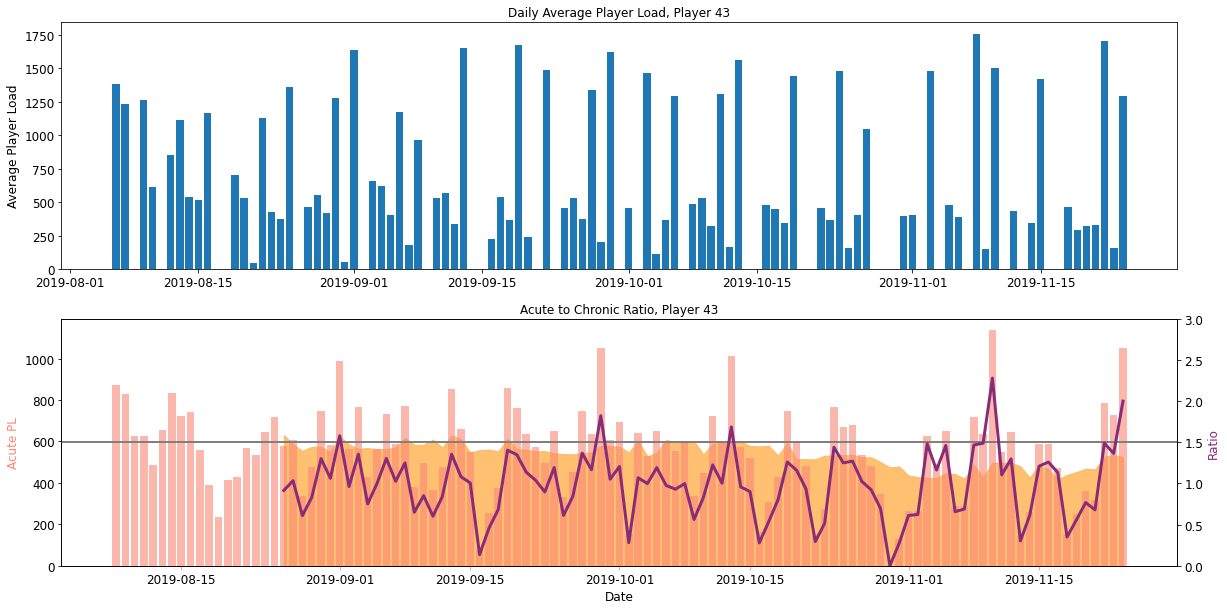

In [30]:
fig, axs = plt.subplots(2,figsize=(20, 10))

axs[0].bar(df_43.index, df_43["Total.Player.Load"])
#axs[0].set_xlabel("Date", fontsize=12)
axs[0].tick_params(axis='x', labelsize=12,)
axs[0].set_ylabel('Average Player Load', fontsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_title("Daily Average Player Load, Player 43", fontsize=12)

color='#FA8775'
axs[1].set_xlabel("Date", fontsize=12)
axs[1].tick_params(axis='x', labelsize=12, color=color)
axs[1].set_ylabel('Acute PL', color=color, fontsize=12)
axs[1].bar(df_43.index, df_43["Acute_PL"], color=color, alpha=0.6)
axs[1].tick_params(axis='y', labelsize=12)
color='#FFB14E'
axs[1].fill_between(df_43.index, df_43["Chronic_PL"], color=color, alpha=0.8)
axs[1] = plt.gca()
axs[1].set_title("Acute to Chronic Ratio, Player 43", fontsize=12)
axs1 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

color='#882C78'
axs1.set_ylabel('Ratio', fontsize=12, color=color)  # we already handled the x-label with ax1
axs1.plot(df_43.index, df_43["Acute:Chronic"], color=color, linewidth=3.0)
axs1.tick_params(axis='y', labelsize=12)
axs1 = plt.gca()

# To see how the acute to chronic workload ratio drops over the first 28 days, 
# comment out this line by adding a '#' in front of the line
axs1.set_ylim([0,3.0])

axs1.axhline(y=1.5,c="gray",linewidth=2,zorder=0)

### 2) The entire team
In a similar vein to the previous example, we can take the team as a whole and calculate their training load metrics. This can serve to the coaching team as a guideline to reduce the training for the team in occassions when they're generally tired. 

In [31]:
df_all = session_df.groupby("Date").sum()
df_all = df_all.resample('D').sum()
df_all = df_all.fillna(0)

df_all["Acute_PL"] = (df_all.loc[:,"Total.Player.Load"].rolling('3D', ACUTE_TL_CONSTANT).sum())/ACUTE_TL_CONSTANT
df_all["Chronic_PL"] = (df_all.loc[:,"Total.Player.Load"].rolling('21D', CHRONIC_TL_CONSTANT).sum())/CHRONIC_TL_CONSTANT
df_all["Acute:Chronic"] = df_all.loc[:,"Acute_PL"]/df_all.loc[:,"Chronic_PL"]
df_all.head(30)

,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,,,,,
2019-08-06,21457.62648,578.47427,9810,1464,7896.95444,2718.800956,NaN,NaN,NaN
2019-08-07,21576.70582,320.09410,9141,1221,6727.04942,3960.461380,NaN,NaN,NaN
2019-08-08,0.00000,0.00000,0,0,0.00000,0.000000,14344.777433,NaN,NaN
2019-08-09,19715.55092,255.97996,7105,1023,5253.16905,3173.360914,13764.085580,NaN,NaN
2019-08-10,8707.56628,113.13464,3862,693,2801.49209,1653.143806,9474.372400,NaN,NaN
2019-08-11,0.00000,0.00000,0,0,0.00000,0.000000,9474.372400,NaN,NaN
2019-08-12,13495.42490,135.41093,3485,411,2492.89425,1986.196151,7400.997060,NaN,NaN
2019-08-13,16179.74976,196.51043,7326,327,5058.30292,3311.968716,9891.724887,NaN,NaN
2019-08-14,9114.80171,112.96797,3549,303,2456.94682,1613.696645,12929.992123,NaN,NaN


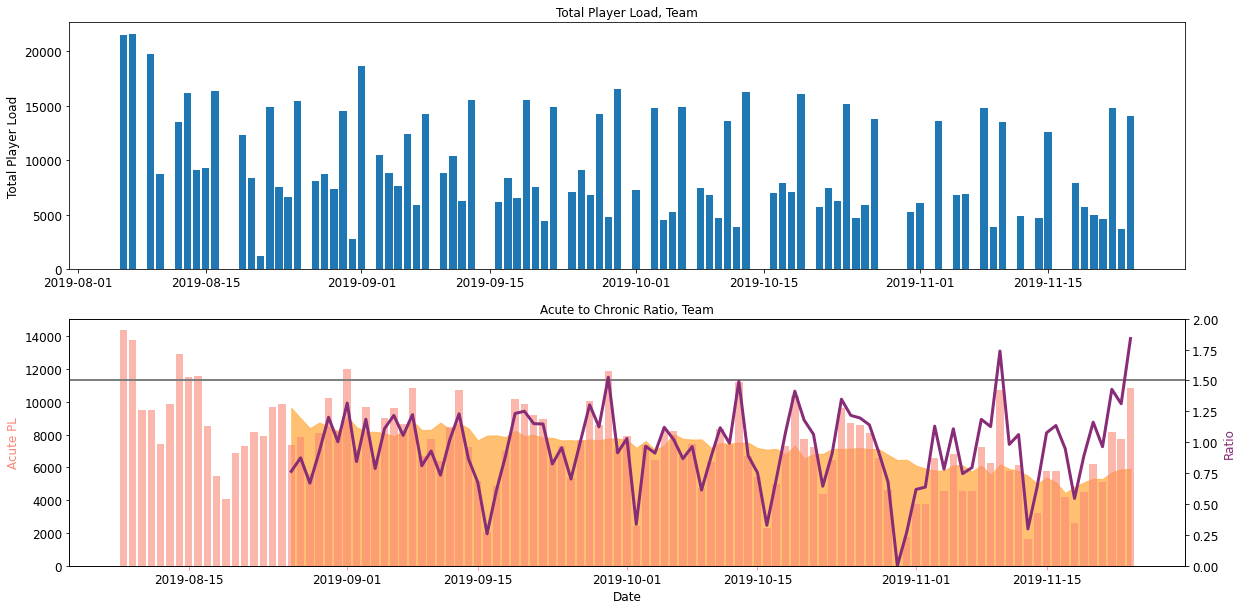

In [32]:
fig, axs = plt.subplots(2,figsize=(20, 10))

axs[0].bar(df_all.index, df_all["Total.Player.Load"])
#axs[0].set_xlabel("Date", fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].set_ylabel('Total Player Load', fontsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_title("Total Player Load, Team", fontsize=12)

color='#FA8775'
axs[1].set_xlabel("Date", fontsize=12)
axs[1].tick_params(axis='x', labelsize=12, color=color)
axs[1].set_ylabel('Acute PL', color=color, fontsize=12)
axs[1].bar(df_all.index, df_all["Acute_PL"], color=color, alpha=0.6)
axs[1].tick_params(axis='y', labelsize=12)

color='#FFB14E'
axs[1].fill_between(df_all.index, df_all["Chronic_PL"], color=color, alpha=0.8)
axs[1] = plt.gca()
axs[1].set_title("Acute to Chronic Ratio, Team", fontsize=12)
axs1 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

color='#882C78'
axs1.set_ylabel('Ratio', fontsize=12, color=color)  # we already handled the x-label with ax1
axs1.plot(df_all.index, df_all["Acute:Chronic"], color=color, linewidth=3.0)
axs1.tick_params(axis='y', labelsize=12)
axs1 = plt.gca()

# To see how the acute to chronic workload ratio drops over the first 28 days, 
# comment out this line by adding a '#' in front of the line
axs1.set_ylim([0,2.0])

axs1.axhline(y=1.5,c="gray",linewidth=2,zorder=0)

In general, the peaks coincide with those of the previous example. However, we see that at team level the training load is relatively well kept in check until almost the end of the season. There are very few instances were the ACWR went over the (arbitrary) 1.5 threshold:
* 2019-09-29 	
* 2019-11-10 	
* 2019-11-24 	

In [33]:
df_all.loc[df_all["Acute:Chronic"]>1.5]

,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,,,,,
2019-09-29,16510.51763,160.57588,3930,503,2935.97880,1955.542138,11844.918730,7760.283862,1.526351
2019-11-10,13527.89556,143.96280,2777,373,2265.97600,1552.761600,10746.631557,6181.182352,1.738605
2019-11-24,14027.23956,141.80282,1751,0,1432.14411,1558.522129,10856.481493,5902.242050,1.839383


To manage the training load, hard work has to be combined with easy sessions too. These were the shortest sessions (as accumulated duration) for the team if we don't take into account zero values. 

In [36]:
df_all[df_all["session_duration"]!=0].nsmallest(5, ["session_duration"])

,Total.Player.Load,Player.Load.Per.Minute,Maximum.Heart.Rate,Minimum.Heart.Rate,Avg.Heart.Rate,session_duration,Acute_PL,Chronic_PL,Acute:Chronic
Date,,,,,,,,,
2019-08-21,1223.74407,33.08703,1815,542,1453.59259,379.616189,7290.630430,NaN,NaN
2019-08-31,2795.59493,110.38019,2290,298,1782.63425,401.229387,8239.477840,8207.376293,1.003911
2019-11-09,3891.76382,132.47594,1633,118,1298.33985,512.630654,6237.333037,5536.996850,1.126483
2019-10-12,3852.33775,125.61479,2997,0,2136.27319,570.699974,7386.412103,7449.041558,0.991592
2019-10-04,4527.04896,120.00095,2816,614,2118.32040,668.066767,6451.473437,7075.382732,0.911820
